Data:
Try one hot vs label encoding
Different data loading/ pipeline methods (DataImageGenerator, tf.data.dataset, pandas)
data augmentation
prefetch
batch size

Model:
dropout
fully connected shape
optimizer
loss function
different model architectures and sizes
weight pruning

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
import os

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from sklearn.preprocessing import LabelEncoder

# Loading and Investigating Data

### Data Investigation and label creation

In [19]:
data_dir = "C:\\Users\\jgett\\OneDrive\\Desktop\\AI\\Projects\\Kaggle\\Data\\dogs\\"
train_dir = data_dir + 'train'

labels = pd.read_csv(data_dir + 'labels.csv')
print(labels.head) 

# Creating array of image paths
img_paths = []
for id in labels['id']:
    img_paths.append(data_dir + "train\\" + id + ".jpg")
    
print(img_paths[:5])

<bound method NDFrame.head of                                      id                     breed
0      000bec180eb18c7604dcecc8fe0dba07               boston_bull
1      001513dfcb2ffafc82cccf4d8bbaba97                     dingo
2      001cdf01b096e06d78e9e5112d419397                  pekinese
3      00214f311d5d2247d5dfe4fe24b2303d                  bluetick
4      0021f9ceb3235effd7fcde7f7538ed62          golden_retriever
...                                 ...                       ...
10217  ffd25009d635cfd16e793503ac5edef0                    borzoi
10218  ffd3f636f7f379c51ba3648a9ff8254f            dandie_dinmont
10219  ffe2ca6c940cddfee68fa3cc6c63213f                  airedale
10220  ffe5f6d8e2bff356e9482a80a6e29aac        miniature_pinscher
10221  fff43b07992508bc822f33d8ffd902ae  chesapeake_bay_retriever

[10222 rows x 2 columns]>
['C:\\Users\\jgett\\OneDrive\\Desktop\\AI\\Projects\\Kaggle\\Data\\dogs\\train\\000bec180eb18c7604dcecc8fe0dba07.jpg', 'C:\\Users\\jgett\\OneDrive\\Des

In [3]:
# Creating integer classes
le = LabelEncoder()
int_input = le.fit_transform(labels.iloc[:,1].values)
labels['int_class'] = int_input

labels[:10]

,id,breed,int_class
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,19
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,37
2,001cdf01b096e06d78e9e5112d419397,pekinese,85
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,15
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,49
5,002211c81b498ef88e1b40b9abf84e1d,bedlington_terrier,10
6,00290d3e1fdd27226ba27a8ce248ce85,bedlington_terrier,10
7,002a283a315af96eaea0e28e7163b21b,borzoi,18
8,003df8b8a8b05244b1d920bb6cf451f9,basenji,7
9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound,97


In [6]:
# Creating one hot encoded labels
cat_count = 120  #depth or the number of categories
oh_input = tf.one_hot(int_input, cat_count) #apply one-hot encoding 
print(oh_input.numpy())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### Data Pipeline

Some Notes:  
    -ImageDataGenerator is deprecated and does not utilize tf.data  
    -can use tf.keras.preprocessing.image_dataset_from_directory IF classes are separated by subfolders  
    -use tfRecords for optimal efficiency  

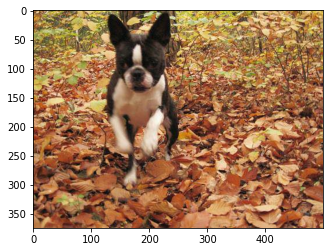

****Image:  [0.41960788 0.1764706  0.        ]
****Label:  19


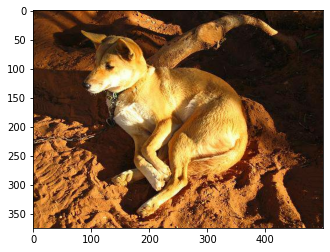

****Image:  [0.20000002 0.13333334 0.10196079]
****Label:  37


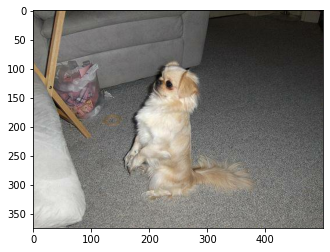

****Image:  [0.3803922  0.3803922  0.34901962]
****Label:  85


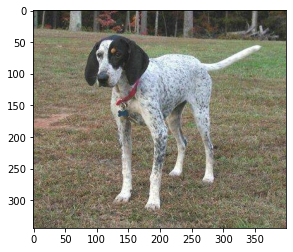

****Image:  [0.27450982 0.25882354 0.24705884]
****Label:  15


In [ ]:
def read_and_decode(filename):
    # Returns a tensor with byte values of the entire contents of the input filename.
    img = tf.io.read_file(filename)
    # Decoding raw JPEG tensor data into 3D (RGB) uint8 pixel value tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # Converting from uint8 [0,256] pixel values to float32 [0, 1] pixel values
    img = tf.image.convert_image_dtype(img, tf.float32)
    # Resize for various architectures
    img = tf.image.resize(img, [128, 128])
    
    return img

# Using function above to map image file paths to normalized RGB pixel values
imgs_ds = tf.data.Dataset.list_files('C:/Users/jgett/OneDrive/Desktop/AI/Projects/Kaggle/Data/dogs/train/*', shuffle=False)
imgs_ds = imgs_ds.map(read_and_decode)

# Creating two labels datasets, one-hot and integer labels. Will see which one performs best.
labels_oh = tf.data.Dataset.from_tensor_slices(oh_input)
labels_int = tf.data.Dataset.from_tensor_slices(int_input)

# Combining image ds and label ds into one (for both one-hot and int labels)
train_ds_oh = tf.data.Dataset.zip((imgs_ds, labels_oh))
train_ds_int = tf.data.Dataset.zip((imgs_ds, labels_int))

# Visualizing dataset
for image, label in train_ds_int.take(4):
    plt.imshow(image.numpy())
    plt.show()
    print("****Image: ",image.numpy()[0][0])
    print("****Label: ",label.numpy())

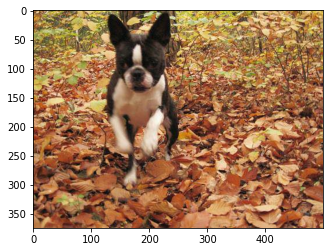

****Image:  [0.41960788 0.1764706  0.        ]
****Label:  19


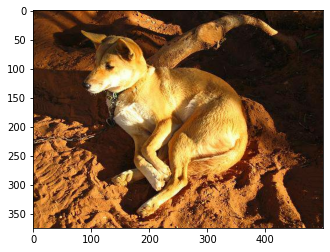

****Image:  [0.20000002 0.13333334 0.10196079]
****Label:  37


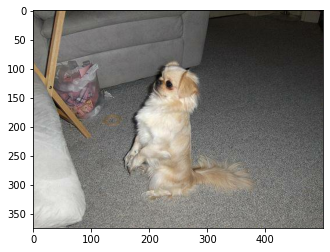

****Image:  [0.3803922  0.3803922  0.34901962]
****Label:  85


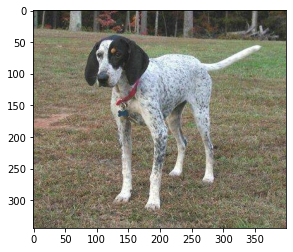

****Image:  [0.27450982 0.25882354 0.24705884]
****Label:  15


In [22]:
################## ALTERNATIVE ###########################
# Alternative dataset creation method
def read_and_decode2(filename, label):
    # Returns a tensor with byte values of the entire contents of the input filename.
    img = tf.io.read_file(filename)
    # Decoding raw JPEG tensor data into 3D (RGB) uint8 pixel value tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # Converting from uint8 [0,256] pixel values to float32 [0, 1] pixel values
    img = tf.image.convert_image_dtype(img, tf.float32)
    # Resize for various architectures
    img = tf.image.resize(img, [128, 128])
    
    return img, label

train_ds_oh = tf.data.Dataset.from_tensor_slices((img_paths, oh_input))
train_ds_int = tf.data.Dataset.from_tensor_slices((img_paths, int_input))

train_ds_oh = train_ds_oh.map(read_and_decode2)
train_ds_int = train_ds_int.map(read_and_decode2)

# Visualizing dataset
for image, label in train_ds_int.take(4):
    plt.imshow(image.numpy())
    plt.show()
    print("****Image: ",image.numpy()[0][0])
    print("****Label: ",label.numpy())

In [ ]:
#Try TF Records

In [ ]:
# Dataset Optimization

# Is there a purpose to this?
#dataset = dataset.shuffle(len(filenames))

#Should keep everything in memory
#dataset = dataset.cache()